## Imports

In [ ]:
import random
import torch
from torch import nn, optim
import math
import numpy as np
from matplotlib import pyplot as plt
from IPython import display

from mlmvn.layers import (
    FirstLayer,
    HiddenLayer,
    OutputLayer,
    cmplx_phase_activation,
    MyDropout,
)
from mlmvn.loss import ComplexMSELoss
from mlmvn.optim import MySGD, ECL

## Helper Functions

In [ ]:
def set_default(figsize=(10, 10), dpi=100):
    plt.rc("figure", figsize=figsize, dpi=dpi)


def plot_data_old(X, y, d=0, auto=False, zoom=1):
    X = X.cpu()
    y = y.cpu()
    plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
    plt.axis("square")
    plt.axis(np.array((-1.1, 1.1, -1.1, 1.1)) * zoom)
    if auto is True:
        plt.axis("equal")
    plt.axis("off")

    _m, _c = 0, ".15"
    plt.axvline(0, ymin=_m, color=_c, lw=1, zorder=0)
    plt.axhline(0, xmin=_m, color=_c, lw=1, zorder=0)


def plot_data(X, y):
    X = X.cpu()
    y = y.cpu()
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap="tab10")
    plt.title("Spirals Dataset")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.grid()
    plt.show()


def plot_model(X, y, model):
    model.cpu()
    mesh = np.arange(-1.1, 1.1, 0.01)
    xx, yy = np.meshgrid(mesh, mesh)
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
        Z = model(data).detach()
    Z = np.argmax(Z, axis=1).reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3)
    plot_data(X, y)


def accuracy(out, yb):
    out = out.type(torch.double)
    yb = yb.type(torch.double)
    x = 0
    for i in range(len(out)):
        x += torch.equal(out[i], yb[i])
    return x / len(out)


def angle2class(x: torch.tensor, categories: int, periodicity: int) -> torch.tensor:
    tmp = x.angle() + 2 * np.pi
    angle = torch.remainder(tmp, 2 * np.pi)

    # This will be the discrete output (the number of sector)
    o = torch.floor(categories * periodicity * angle / (2 * np.pi))
    return torch.remainder(o, categories)


def plot_loss(title, losses, scores):
    plt.rcParams["axes.grid"] = True
    fig, (ax1) = plt.subplots(1, 1, figsize=(8, 4))
    fig.suptitle("CVNN - Moons")
    ax1.plot(np.linspace(1, len(losses), len(losses)), losses)
    ax1.set_xlabel("Epoch")
    ax1.set_xlim(0, len(losses))

    ax1.plot(np.linspace(1, len(scores), len(scores)), scores)
    ax1.set_xlabel("Epoch")
    ax1.set_xlim(0, len(losses))

    ax1.legend(["Acc", "Loss"])

    plt.show()

In [ ]:
set_default()

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
torch.cuda.is_available()

False

## Dataset - Generate Spirals

In [ ]:
seed = 12345
random.seed(seed)
torch.manual_seed(seed)
N = 1000  # num_samples_per_class
D = 2  # dimensions
C = 2  # num_classes
H = 100  # num_hidden_units

In [ ]:
X = torch.zeros(N * C, D).to(device)
y = torch.zeros(N * C, dtype=torch.long).to(device)
for c in range(C):
    index = 0
    t = torch.linspace(0, 1, N)
    # When c = 0 and t = 0: start of linspace
    # When c = 0 and t = 1: end of linpace
    # This inner_var is for the formula inside sin() and cos() like sin(inner_var) and cos(inner_Var)
    inner_var = (
        torch.linspace(
            # When t = 0
            (2 * math.pi / C) * (c),
            # When t = 1
            (2 * math.pi / C) * (2 + c),
            N,
        )
        + torch.randn(N) * 0.2
    )

    for ix in range(N * c, N * (c + 1)):
        X[ix] = t[index] * torch.FloatTensor(
            (math.sin(inner_var[index]), math.cos(inner_var[index]))
        )
        y[ix] = c
        index += 1

print("Shapes:")
print("X:", tuple(X.size()))
print("y:", tuple(y.size()))

Shapes:
X: (2000, 2)
y: (2000,)


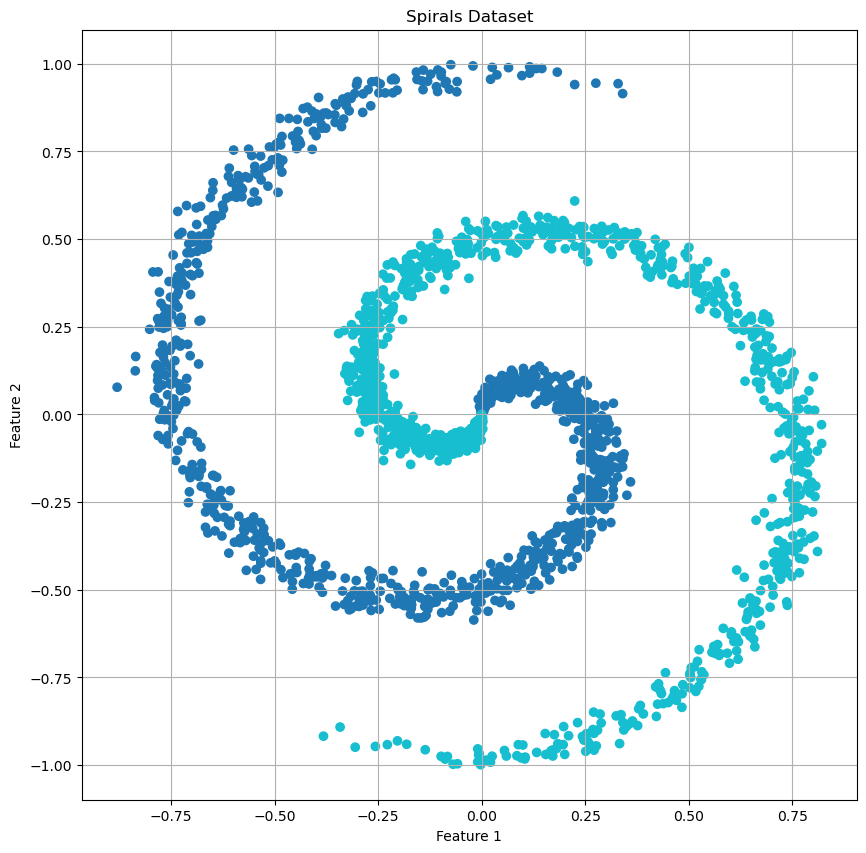

In [ ]:
# visualise the data
plot_data(X, y)

## MLMVN Model

In [ ]:
categories = 2
periodicity = 1
epochs = 20
batch_size = 100
lr = 1

In [ ]:
class MLMVN(nn.Module):
    def __init__(self):
        super().__init__()
        self.first_linear = FirstLayer(2, 5)
        self.phase_act1 = cmplx_phase_activation()
        self.hidden_linear = HiddenLayer(5, 5)
        self.phase_act2 = cmplx_phase_activation()
        self.output_linear = OutputLayer(5, 1)
        self.phase_act3 = cmplx_phase_activation()

    def forward(self, x):
        x = self.first_linear(x)
        x = self.phase_act1(x)
        x = self.hidden_linear(x)
        x = self.phase_act2(x)
        x = self.output_linear(x)
        x = self.phase_act3(x)
        return x

    def predict(self, x, loss):
        """
        Performs the prediction task of the network

        Args:
          x: torch.Tensor
            Input tensor of size ([3])

        Returns:
          Most likely class i.e., Label with the highest score
        """
        # Pass the data through the networks
        output = self.forward(x)

        # # Choose the label with the highest score
        # return torch.argmax(output, 1)
        return output


# Implement the train function given a training dataset X and correcsponding labels y
def train(
    model, X, y, epochs, batch_size, optimizer, criterion, categories, periodicity
):
    # List of losses for visualization
    losses = []
    scores = []

    for i in range(epochs):
        # Pass the data through the network and compute the loss
        # We'll use the whole dataset during the training instead of using batches
        # in to order to keep the code simple for now.

        batch_loss = []

        for j in range((X.shape[0] - 1) // batch_size + 1):
            start_j = j * batch_size
            end_j = start_j + batch_size
            xb = X[start_j:end_j]
            yb = y[start_j:end_j]

            # Forward pass: Compute predicted y by passing x to the model
            y_pred = model(xb)
            loss = criterion(y_pred, yb, categories, periodicity)

            if i % 10 == 9:
                print(torch.abs(loss))
            batch_loss.append((torch.abs(loss)).detach().numpy())

            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step(inputs=xb, layers=list(model.children()))

        losses.append(sum(batch_loss) / len(batch_loss))
        y_pred = model(X)
        y_pred = angle2class(y_pred, categories, periodicity)
        scores.append(accuracy(y_pred.squeeze(), y))

        log_dict = {
            "loss": torch.tensor(losses[-1]),
            "acc": torch.tensor(scores[-1]),
        }

    return (
        losses,
        scores,
    )

In [ ]:
model = MLMVN()
criterion = ComplexMSELoss.apply
# optimizer = torch.optim.SGD(model.parameters(), lr=1)
optimizer = ECL(model.parameters(), lr=lr)

#  capture a dictionary of hyperparameters with config
config_dict = {
    "learning_rate": lr,
    "epochs": epochs,
    "batch_size": batch_size,
    "optim": "ECL",
    "categories": categories,
    "periodicity": periodicity,
}

In [ ]:
X = X.type(torch.cdouble)

In [ ]:
y_pred = model(X[1:])

In [ ]:
y_pred
y_pred = angle2class(y_pred, categories, periodicity)
acc = accuracy(y_pred.squeeze(), y[1:])

In [ ]:
X[1:]

tensor([[ 1.0367e-04+0.j,  9.9562e-04+0.j],
        [-1.1138e-03+0.j,  1.6636e-03+0.j],
        [ 3.2262e-04+0.j,  2.9856e-03+0.j],
        ...,
        [-5.8667e-02+0.j, -9.9627e-01+0.j],
        [-2.8229e-03+0.j, -9.9900e-01+0.j],
        [-6.9269e-02+0.j, -9.9760e-01+0.j]], dtype=torch.complex128)

In [ ]:
y_pred

tensor([[1.],
        [1.],
        [1.],
        ...,
        [0.],
        [0.],
        [0.]], dtype=torch.float64, grad_fn=<RemainderBackward0>)

In [ ]:
acc

0.49974987493746875

In [ ]:
(losses, scores,) = train(
    model,
    X[1:],
    y[1:],
    epochs=epochs,
    batch_size=batch_size,
    optimizer=optimizer,
    criterion=criterion,
    categories=categories,
    periodicity=periodicity,
)

tensor(1.7948, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(1.5242, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(1.8572, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(1.9880, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(1.9598, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(1.9888, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(2.9800, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(3.7226, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.9685, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(0.9082, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(2.7025, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(2.0528, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(1.8027, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(4.5817, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(4.8516, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(4.8728, dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor(5.1116, dtype=torch.float64, grad

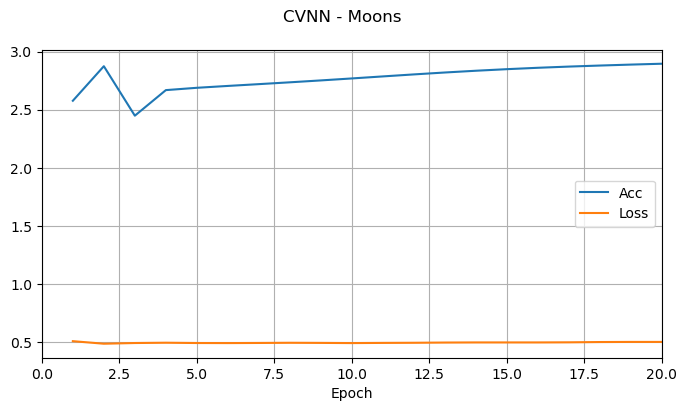

In [ ]:
# | echo: false
plot_loss("CVNN - Moons", losses, scores)

In [ ]:
y_pred = model(X[1:])
y_pred = angle2class(y_pred, categories, periodicity)
acc = accuracy(y_pred.squeeze(), y[1:])
print("Train Acc.: ", acc)

Train Acc.:  0.5012506253126563
